# MOPS for KBmod

Based off the CNN developed for the first ML search of the New Horizons 2020 search


In [1]:
import os, glob, sys
import time

import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv3D, Conv2D, MaxPool3D, MaxPool2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.visualization import interval

from trippy import tzscale
from trippy.trippy_utils import expand2d, downSample2d

from convenience_utils import calc_ecliptic_angle

from utils import shuffle

from ensemble import convnet_model
from keras_filter import *


from scipy.stats import chi2
def poisson_interval(k, alpha=0.33):
    """
    uses chisquared info to get the poisson interval. Uses scipy.stats
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    return [low, high]

def eff(m, eff_max = 0.76, c=0.0056, M_0=26.41, sig=0.25):
    return (eff_max-c*(m-21.0)**2)/(1+np.exp((m-M_0)/sig))
    

In [2]:

image_data_type = 'float32'

batch_size = 4096 

useTripletGrids = True

useMedForNans = False #otherwise zero is used
useZscale = False


max_dist_threshold = 6.0


model_dirs = ['ML_KBmod_modelSave_19_22.8_0',
              'ML_KBmod_modelSave_19_22.8_1',
              'ML_KBmod_modelSave_19_22.8_2',
              'ML_KBmod_modelSave_22.5_23.8_0',
              'ML_KBmod_modelSave_22.5_23.8_1',
              'ML_KBmod_modelSave_22.5_23.8_2',
              'ML_KBmod_modelSave_23.5_24.8_0',
              'ML_KBmod_modelSave_23.5_24.8_1',
              'ML_KBmod_modelSave_23.5_24.8_2',
              'ML_KBmod_modelSave_24.5_25.8_0',
              'ML_KBmod_modelSave_24.5_25.8_1',
              'ML_KBmod_modelSave_24.5_25.8_2',
              'ML_KBmod_modelSave_25.5_26.8_0',
              'ML_KBmod_modelSave_25.5_26.8_1',
              'ML_KBmod_modelSave_25.5_26.8_2',
              'ML_KBmod_modelSave_26.0_26.8_0',
              'ML_KBmod_modelSave_26.0_26.8_1',
              'ML_KBmod_modelSave_26.0_26.8_2',
             ]

conf_thresholds = np.array([
                           [0.99, 0.83, 0.84], #0.9
                           [0.96, 0.85, 0.994], #0.8 or 0.85
                           [0.98, 0.88, 0.94], # 0.95 or a little higher
                           [0.97, 0.88, 0.99], # 0.95
                           [0.93, 0.96, 0.92], # 0.8 or 0.85
                           [0.8,  0.82,  0.75], # 0.95
                  ])

#a=5
#b=6
#model_dirs = model_dirs[a*3:b*3]
#conf_thresholds = conf_thresholds[a:b]

"""These are some of the flags."""
visits = ['03072', '03093']
#visits = ['03447']

chips = []
#for i in range(103,-1,-1):
for i in range(0, 40, 1):
    if i==9: continue
    if i in [20,34]: continue
    #if i in [17, 22, 29, 54, 76, 77, 81]:
    #    continue
    chips.append(str(i).zfill(3))


In [3]:
# load the model


keras_filter = filter_stamps(model_dirs)


   Loading model ML_KBmod_modelSave_19_22.8_0/model_0


   Loading model ML_KBmod_modelSave_19_22.8_0/model_1


   Loading model ML_KBmod_modelSave_19_22.8_0/model_2


   Loading model ML_KBmod_modelSave_19_22.8_0/model_3


   Loading model ML_KBmod_modelSave_19_22.8_0/model_4


   Loading model ML_KBmod_modelSave_19_22.8_1/model_0


   Loading model ML_KBmod_modelSave_19_22.8_1/model_1


   Loading model ML_KBmod_modelSave_19_22.8_1/model_2


   Loading model ML_KBmod_modelSave_19_22.8_1/model_3


   Loading model ML_KBmod_modelSave_19_22.8_1/model_4


   Loading model ML_KBmod_modelSave_19_22.8_2/model_0


   Loading model ML_KBmod_modelSave_19_22.8_2/model_1


   Loading model ML_KBmod_modelSave_19_22.8_2/model_2


   Loading model ML_KBmod_modelSave_19_22.8_2/model_3


   Loading model ML_KBmod_modelSave_19_22.8_2/model_4


   Loading model ML_KBmod_modelSave_22.5_23.8_0/model_0


   Loading model ML_KBmod_modelSave_22.5_23.8_0/model_1


   Loading model ML_KBmod_modelSave_22.5_23

In [4]:
rots_dict = {'000': 0, '001': 0, '002': 0, '003': 0, '004': 0, '005': 0, '006': 0, '007': 0, '008': 0, '010': 0, 
             '011': 0, '012': 0, '013': 0, '014': 0, '015': 0, '016': 2, '017': 2, '018': 2, '019': 0, '020': 0, 
             '021': 0, '022': 2, '023': 2, '024': 2, '025': 2, '026': 0, '027': 0, '028': 0, '029': 0, '030': 2, 
             '031': 2, '032': 2, '033': 2, '034': 0, '035': 0, '036': 0, '037': 0, '038': 2, '039': 2, '040': 2, 
             '041': 2, '042': 0, '043': 0, '044': 0, '045': 0, '046': 2, '047': 2, '048': 2, '049': 2, '050': 0, 
             '051': 0, '052': 0, '053': 0, '054': 2, '055': 2, '056': 2, '057': 2, '058': 0, '059': 0, '060': 0, 
             '061': 0, '062': 2, '063': 2, '064': 2, '065': 2, '066': 0, '067': 0, '068': 0, '069': 0, '070': 2, 
             '071': 2, '072': 2, '073': 2, '074': 0, '075': 0, '076': 0, '077': 0, '078': 2, '079': 2, '080': 2, 
             '081': 0, '082': 0, '083': 0, '084': 2, '085': 2, '086': 2, '087': 2, '088': 2, '089': 2, '090': 2, 
             '091': 2, '092': 2, '093': 2, '094': 2, '095': 2, '096': 2, '097': 2, '098': 2, '099': 2, '100': 1, 
             '101': 1, '102': 3, '103': 3}

calculateRots = False
if calculateRots:
    reference_fits_images = []
    ecl_angles = []
    stamp_files = []
    kb_xys,fs = [],[]
    for i, c in enumerate(chips):
        for j, v in enumerate(visits[:1]):
            warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
            reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])
            ecl_ang = calc_ecliptic_angle(reference_fits_images[-1])
            ecl_angles.append(ecl_ang)
            if c=='050':
                ref_ecl_ang = ecl_ang
                print(ref_ecl_ang)
    ecl_angles = np.array(ecl_angles)
    rots = (ref_ecl_ang-ecl_angles)*180./np.pi
    print(len(rots))
    corners = np.array([-270., -180., -90., 0., 90., 180., 270.])
    for i,r in enumerate(rots):
        rot = corners[np.argmin(np.abs(r-corners))]
        if rot<0: 
            rot+=360.
        print(chips[i%len(chips)],r,rot)
        rots[i] = rot/90.
    rots = rots.astype(np.int)

    rots_dict = {}
    for i, c in enumerate(chips):
        rots_dict[c] = rots[i]
    print(rots_dict)
else:
    rots=[]
    for i, c in enumerate(chips):
        rots.append(rots_dict[c])

In [5]:
gridType = ''
if useTripletGrids:
    gridType = '_tg'
    
all_probs = []
kf_classes = []
all_kb_xys = []
all_p_xys = []
reference_fits_images = []
counter = 0
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        all_probs.append([])
        print(v,c)
        stamps_path = f'/media/fraserw/rocketdata/Projects/kbmod/stamps/{v}'
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_file = f'{stamps_path}/stamps{gridType}_{c}.pickle'
        
        ### get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        ### load the kbmod results
        kb_xy = []
        if os.path.isfile(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper_0/results_MERGED.txt'):
            #check if the kbmod results from CANFAR are available
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper_0/results_MERGED.txt') as han:
                data = han.readlines()
        else:
            ### otherwise open a local copy
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_lower/results_LOWER.txt') as han:
                data = han.readlines()
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper/results_UPPER.txt') as han:
                data += han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        if v == '03072':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_May25-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0218606-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03093':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_June19-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0220262-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03148':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_Aug11-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0223640-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03447':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_21_June-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0255418-{c}.plantList') as han:
                data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            #if float(s[9])>27: continue
            ra,dec = float(s[1]), float(s[2])
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), 0])
                
            if s[0]=='4766':
                ref_x, ref_y = x, y
                dist = ((kb_xy[:, 0] - ref_x)**2 + (kb_xy[:, 1] - ref_y)**2)**0.5
                ref_arg = np.argmin(dist)
                print('Reference xy:', ref_x, ref_y)
                print('Min dist to reference object: ', np.min(dist))
                print()
        p_xy = np.array(p_xy)
        w = np.where(p_xy[:, 2]<27)
        p_xy = p_xy[w]

        #load the stamps
        print(stamp_file)
        with open(stamp_file, 'rb') as han:
            f = pickle.load(han)
        
        ### trim to just the best cutout
        f = f[:,5,:,:]
        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))

        w = np.where(np.isnan(f))
        f[w] = 0.0

        ### rotate frames
        # k should be -rots!
        if rots[counter%len(chips)]!=0:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))

        f = np.expand_dims(f, axis=-1)
        print(f.shape)

        #for kk in range(len(cn_models)):
        #    mean, std = means[kk], stds[kk]
        #    F = (f-mean)/std
        #    probs = cn_models[kk].predict(F, verbose=0)[:, 1]
        #    print(kk, mean, std)
        #    all_probs[-1].append(probs)
        all_p_xys.append(p_xy)
        all_kb_xys.append(kb_xy)
        
        classes = keras_filter.filter_stamps(f, np.array(conf_thresholds)*0.95, class_w_triplets=True)
        all_probs[-1] = np.copy(keras_filter.all_probs)
        kf_classes.append(classes)
print(p_xy)

03072 000
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_000.pickle
(2504, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03093 000
/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_000.pickle
(2617, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Pr

/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_006.pickle
(3916, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03072 007
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_007.pickle
(3768, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting f

Predicting for model 18 of 18
03072 014
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_014.pickle
(3985, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03093 014
/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_014.pickle
(3522, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
P

Predicting for model 18 of 18
03093 021
Reference xy: 1650.2743666473748 2148.3743355132265
Min dist to reference object:  4.434112644567838

/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_021.pickle
(4241, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03072 022
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_022.pickle
(2574, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for 

Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03072 028
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_028.pickle
(4026, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03093 028
/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_028.pickle
(3864, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of

Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03093 035
/media/fraserw/rocketdata/Projects/kbmod/stamps/03093/stamps_tg_035.pickle
(3677, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 of 18
Predicting for model 3 of 18
Predicting for model 4 of 18
Predicting for model 5 of 18
Predicting for model 6 of 18
Predicting for model 7 of 18
Predicting for model 8 of 18
Predicting for model 9 of 18
Predicting for model 10 of 18
Predicting for model 11 of 18
Predicting for model 12 of 18
Predicting for model 13 of 18
Predicting for model 14 of 18
Predicting for model 15 of 18
Predicting for model 16 of 18
Predicting for model 17 of 18
Predicting for model 18 of 18
03072 036
/media/fraserw/rocketdata/Projects/kbmod/stamps/03072/stamps_tg_036.pickle
(2195, 21, 21, 1)
Predicting for model 1 of 18
Predicting for model 2 o

5254.0 2163.0


/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


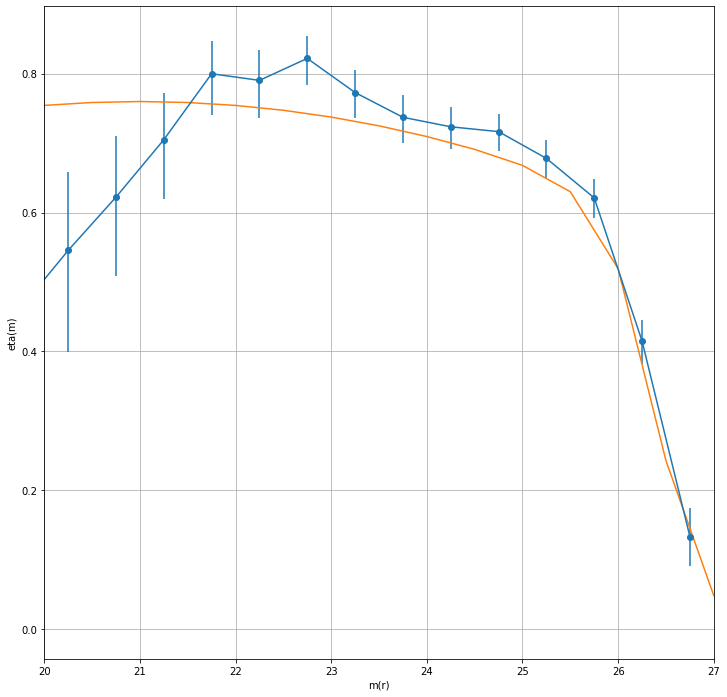

In [6]:
m_bins = np.arange(19, 29, 0.5)
n_p = m_bins*0.0
n_f = m_bins*0.0
n_vet = 0.0
n_plant_found = 0.0
for counter in range(len(all_p_xys)):
    p_xy = all_p_xys[counter]
    kb_xy = all_kb_xys[counter]
    if len(p_xy)==0: continue
    K = ((p_xy[:, 2] - m_bins[0])/(m_bins[1]-m_bins[0])).astype('int')
    for k in K:
        if k>=0:
            n_p[k]+=1

    w = np.where(kf_classes[counter])
    taken = []
    for i in w[0]:
        d = ((kb_xy[i][0] - p_xy[:, 0])**2 + (kb_xy[i][1] - p_xy[:, 1])**2)**0.5
        arg = np.argmin(d)
        if d[arg]<=max_dist_threshold and arg not in taken:
            k = int((p_xy[arg][2]-m_bins[0])/(m_bins[1]-m_bins[0]))
            if k>=0:
                n_f[k]+=1.
                n_plant_found +=1
                taken.append(arg)
    n_vet += len(w[0])
print(n_vet, n_plant_found)

eff_best = n_f/n_p
p_ranges = []
for i,n in enumerate(n_p-n_f):
    p_ranges.append(poisson_interval(n))
p_ranges = np.array(p_ranges)

eff_low = (n_p-p_ranges[:, 1])/n_p
eff_high = (n_p-p_ranges[:, 0])/n_p
eff_low = np.clip(eff_low, 0.0, np.max(eff_low))

fig = pyl.figure('Eff', figsize=(12,12))
sp = fig.add_subplot(111)
sp.errorbar(m_bins+(m_bins[1]-m_bins[0])/2.0, eff_best, yerr = [eff_best-eff_low, eff_high-eff_best], marker='o')

pyl.plot(m_bins, eff(m_bins))    
sp.set_xlim(20,27)
sp.grid()
#sp.legend()
sp.set_xlabel('m(r)')
sp.set_ylabel('eta(m)')
#fig.savefig('/home/fraserw/ownCloud/Efficiency.pdf')
pyl.show()

  1: Found, total, f/t:  255 445 1.7450980392156863
  2: Found, total, f/t:  289 457 1.5813148788927336
  2: Found, total, f/t:  332 341 1.0271084337349397
All: Found, total, f/t:  214 295 1.3785046728971964 

  1: Found, total, f/t:  431 717 1.6635730858468678
  2: Found, total, f/t:  472 493 1.0444915254237288
  2: Found, total, f/t:  339 672 1.9823008849557522
All: Found, total, f/t:  303 512 1.6897689768976898 

  1: Found, total, f/t:  867 1384 1.596309111880046
  2: Found, total, f/t:  853 1333 1.5627198124267292
  2: Found, total, f/t:  822 1385 1.6849148418491484
All: Found, total, f/t:  756 816 1.0793650793650793 

  1: Found, total, f/t:  1034 1465 1.4168278529980658
  2: Found, total, f/t:  1062 1305 1.228813559322034
  2: Found, total, f/t:  1005 1521 1.5134328358208955
All: Found, total, f/t:  863 1162 1.3464658169177288 

  1: Found, total, f/t:  712 1269 1.7823033707865168
  2: Found, total, f/t:  687 1131 1.6462882096069869
  2: Found, total, f/t:  634 1254 1.9779179810

/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid valu

  1: Found, total, f/t:  519 3683 7.096339113680155
  2: Found, total, f/t:  426 5757 13.514084507042254
  2: Found, total, f/t:  499 5212 10.444889779559118
All: Found, total, f/t:  412 878 2.1310679611650487 



/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide


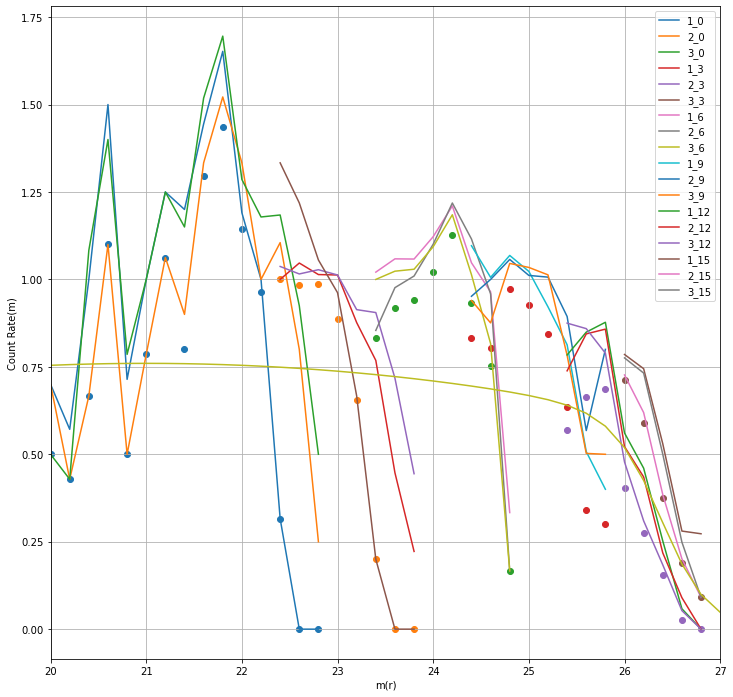

5032


In [10]:
 
for i in range(len(all_kb_xys)):
    if len(all_p_xys[i])>0:
        all_p_xys[i][:, 3] = 0.0
    
#conf_thresholds = [[0.99, 0.83, 0.84],
#                   [0.96, 0.85, 0.994],
#                   [0.98, 0.88, 0.94],
#                   [0.97, 0.88, 0.99], 
#                   [0.93, 0.96, 0.92], 
#                   [0.9, 0.82, 0.75],
#                  ]

# use 0.95 for 20-23.8
# use 0.97 and 0.88 for  23.5-24.8
# use 0.95 and 0.83 for 24.5-25.8
# use 0.91 and 0.95 for 25.5-26.8

fig = pyl.figure('Eff', figsize=(12,12))
sp = fig.add_subplot(111)

n_total_to_vet = 0
for kk in range(0, len(model_dirs), 3):
    s = model_dirs[kk].split('_')
    m_bright, m_faint = float(s[3]), float(s[4])
    
    m_bins = np.arange(19, 29, 0.2)
    n_f1 = m_bins*0.0
    n_f2 = m_bins*0.0
    n_f3 = m_bins*0.0
    n_f = m_bins*0.0
    n_p = m_bins*0.0

    counter = 0
    n_found1 = 0
    n_found2 = 0
    n_found3 = 0
    n_found = 0
    n_plant1 = 0
    n_plant2 = 0
    n_plant3 = 0
    n_plant = 0
    for i, c in enumerate(chips):
        for j, v in enumerate(visits):
            probs1, probs2, probs3 = all_probs[counter][kk], all_probs[counter][kk+1], all_probs[counter][kk+2]
            
            kb_xy = all_kb_xys[counter]
            p_xy1 = np.copy(all_p_xys[counter])
            p_xy2 = np.copy(all_p_xys[counter])
            p_xy3 = np.copy(all_p_xys[counter])
            p_xy = np.copy(all_p_xys[counter])
            
            conf_threshold_1, conf_threshold_2, conf_threshold_3 = conf_thresholds[int(kk/3)]
            #print(conf_threshold_1, conf_threshold_2, m_bright, m_faint)
            if len(p_xy)==0: continue

            W = np.where((p_xy[:, 2]>=m_bright)&(p_xy[:, 2]<=m_faint))
            
            p_xy1 = p_xy1[W]
            p_xy2 = p_xy2[W]
            p_xy3 = p_xy3[W]
            p_xy = p_xy[W]
            if len(p_xy)==0: continue

            #print(probs.shape, kb_xy.shape,p_xy.shape)
            w1 = np.where(probs1>conf_threshold_1)
            for k in w1[0]:
                d = ((kb_xy[k][0] - p_xy[:, 0])**2 + (kb_xy[k][1] - p_xy[:, 1])**2)**0.5
                arg = np.argmin(d)
                #if d[arg]<10:
                #    print(d[arg])
                if d[arg]<=max_dist_threshold:
                    p_xy1[arg][-1] = 1.0
                    #print(p_xy)
                    n_found1+=1
                    k = int((p_xy1[arg][2]-m_bins[0])/(m_bins[1]-m_bins[0]))
                    n_f1[k]+=1.

            w2 = np.where(probs2>conf_threshold_2)
            for k in w2[0]:
                d = ((kb_xy[k][0] - p_xy[:, 0])**2 + (kb_xy[k][1] - p_xy[:, 1])**2)**0.5
                arg = np.argmin(d)
                #if d[arg]<10:
                #    print(d[arg])
                if d[arg]<=max_dist_threshold:
                    p_xy2[arg][-1] = 1.0
                    #print(p_xy)
                    n_found2+=1
                    k = int((p_xy2[arg][2]-m_bins[0])/(m_bins[1]-m_bins[0]))
                    n_f2[k]+=1.

            w3 = np.where(probs3>conf_threshold_3)
            for k in w3[0]:
                d = ((kb_xy[k][0] - p_xy[:, 0])**2 + (kb_xy[k][1] - p_xy[:, 1])**2)**0.5
                arg = np.argmin(d)
                #if d[arg]<10:
                #    print(d[arg])
                if d[arg]<=max_dist_threshold:
                    p_xy3[arg][-1] = 1.0
                    #print(p_xy)
                    n_found3+=1
                    k = int((p_xy3[arg][2]-m_bins[0])/(m_bins[1]-m_bins[0]))
                    n_f3[k]+=1.

            w = np.where((probs1>conf_threshold_1)&(probs2>conf_threshold_2)&(probs3>conf_threshold_3))
            for k in w[0]:
                d = ((kb_xy[k][0] - p_xy[:, 0])**2 + (kb_xy[k][1] - p_xy[:, 1])**2)**0.5
                arg = np.argmin(d)
                #if d[arg]<10:
                #    print(d[arg])
                if d[arg]<=max_dist_threshold:
                    all_p_xys[counter][W[0][arg], 3] = 1.0
                    p_xy[arg, 3] = 1.0
                    n_found+=1
                    k = int((p_xy[arg][2]-m_bins[0])/(m_bins[1]-m_bins[0]))
                    n_f[k]+=1.
            #print(all_p_xys[counter][W])
           
            K = ((p_xy[:,2]-m_bins[0])/(m_bins[1]-m_bins[0])).astype('int')
            for k in K:
                n_p[k]+=1.
            n_plant += len(W[0])
            n_plant1 += len(w2[0])
            n_plant2 += len(w3[0])
            n_plant3 += len(w1[0])
            counter+=1
            #print(v,c,len(p_xy))
    
    if n_found1: print('  1: Found, total, f/t: ', n_found1, n_plant1, n_plant1/n_found1)
    if n_found2: print('  2: Found, total, f/t: ', n_found2, n_plant2, n_plant2/n_found2)
    if n_found3: print('  2: Found, total, f/t: ', n_found3, n_plant3, n_plant3/n_found3)
    if n_found: print('All: Found, total, f/t: ', n_found, n_plant, n_plant/n_found,'\n')

    n_total_to_vet += n_plant

    pyl.plot(m_bins, n_f1/n_p, label=f'1_{kk}')
    pyl.plot(m_bins, n_f2/n_p, label=f'2_{kk}')
    pyl.plot(m_bins, n_f3/n_p, label=f'3_{kk}')
    pyl.scatter(m_bins, n_f/n_p)
    
pyl.plot(m_bins, eff(m_bins))    
sp.set_xlim(20,27)
sp.grid()
sp.legend()
pyl.xlabel('m(r)')
pyl.ylabel('Count Rate(m)')
pyl.savefig('/home/fraserw/ownCloud/fulleff.pdf')
pyl.show()


print(n_total_to_vet)